In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Target,Genetic Markers,Autoantibodies,Family History,Environmental Factors,Insulin Levels,Age,BMI,Physical Activity,Dietary Habits,...,Pulmonary Function,Cystic Fibrosis Diagnosis,Steroid Use History,Genetic Testing,Neurological Assessments,Liver Function Tests,Digestive Enzyme Levels,Urine Test,Birth Weight,Early Onset Symptoms
0,Steroid-Induced Diabetes,Positive,Negative,No,Present,40,44,38,High,Healthy,...,76,No,No,Positive,3,Normal,56,Ketones Present,2629,No
1,Neonatal Diabetes Mellitus (NDM),Positive,Negative,No,Present,13,1,17,High,Healthy,...,60,Yes,No,Negative,1,Normal,28,Glucose Present,1881,Yes
2,Prediabetic,Positive,Positive,Yes,Present,27,36,24,High,Unhealthy,...,80,Yes,No,Negative,1,Abnormal,55,Ketones Present,3622,Yes
3,Type 1 Diabetes,Negative,Positive,No,Present,8,7,16,Low,Unhealthy,...,89,Yes,No,Positive,2,Abnormal,60,Ketones Present,3542,No
4,Wolfram Syndrome,Negative,Negative,Yes,Present,17,10,17,High,Healthy,...,41,No,No,Positive,1,Normal,24,Protein Present,1770,No


In [3]:
data.isnull().sum()

Target                           0
Genetic Markers                  0
Autoantibodies                   0
Family History                   0
Environmental Factors            0
Insulin Levels                   0
Age                              0
BMI                              0
Physical Activity                0
Dietary Habits                   0
Blood Pressure                   0
Cholesterol Levels               0
Waist Circumference              0
Blood Glucose Levels             0
Ethnicity                        0
Socioeconomic Factors            0
Smoking Status                   0
Alcohol Consumption              0
Glucose Tolerance Test           0
History of PCOS                  0
Previous Gestational Diabetes    0
Pregnancy History                0
Weight Gain During Pregnancy     0
Pancreatic Health                0
Pulmonary Function               0
Cystic Fibrosis Diagnosis        0
Steroid Use History              0
Genetic Testing                  0
Neurological Assessm

In [4]:
for column in data.columns:      # iterate through each data column
    if data[column].dtype == 'object':  # Detect categorical data types
        data[column] = data[column].fillna(data[column].mode()[0])   #replace with the most common value
    else:  # Detect numerical 
        data[column] = data[column].fillna(data[column].mean())     #Replace with average of all values


In [5]:
categorical_features = data.select_dtypes(include=['object']).columns.drop('Target') # Selects all categorical data other than the target
encoder = OneHotEncoder(sparse_output=False)  #Ensures output is a numPy Array rather than a matrix
encoded_features = pd.DataFrame(encoder.fit_transform(data[categorical_features]), columns=encoder.get_feature_names_out()) #Hot encodes the data
data = pd.concat([data.drop(categorical_features, axis=1), encoded_features], axis=1) #Drops any columns that were not hot encoded and replaces
#with hot encoded columns


In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Target'])  # Encode target column as integers for label enconding

X = data.drop(columns=['Target'])  # Drops the target column, leaving only features
y = data['Target']  # Target: the 'Target' column with all possible values

#split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [7]:
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    tree_method='hist',
    device='cuda'
) #define Gradient Boosting Classifier with GPU and logLoss settings

# Hyperparameter tuning using GridSearchCV (Is now just the optimal settings because they have been found) originally had multiple numbers in each param
param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [1.0],
    'colsample_bytree': [0.8]
}
#Would be performing hyperparameter tuning if it wasn't already found
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [8]:
y_pred = best_model.predict(X_test)
#predicts evaluation metrics 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy) # (true positives + true negatives) / total number 
print("Precision:", precision) # (true posiitves / (True positives + False positives)
print("Recall:", recall) # (True positives / ture positives + false negatives)
print("F1 Score:", f1)  # 2(Precision * recall) / precision + recall


y_pred_labels = label_encoder.inverse_transform(y_pred)  
y_test_labels = label_encoder.inverse_transform(y_test)  

report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\nClassification Report:\n", report)

Accuracy: 0.9071428571428571
Precision: 0.915557767104341
Recall: 0.9071428571428571
F1 Score: 0.9058953586967617


C:\Users\James Dempsey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Classification Report:
                                             precision    recall  f1-score   support

   Cystic Fibrosis-Related Diabetes (CFRD)       1.00      0.93      0.96      1093
                      Gestational Diabetes       0.90      0.96      0.93      1069
                                      LADA       0.98      0.92      0.95      1044
                                      MODY       0.97      0.83      0.89      1111
          Neonatal Diabetes Mellitus (NDM)       1.00      1.00      1.00      1082
                               Prediabetic       0.96      1.00      0.98      1075
                        Secondary Diabetes       0.79      0.80      0.80      1096
                  Steroid-Induced Diabetes       0.80      0.87      0.84      1055
                           Type 1 Diabetes       0.84      1.00      0.92      1089
                           Type 2 Diabetes       0.98      0.66      0.79      1079
Type 3c Diabetes (Pancreatogenic Diabetes)       0

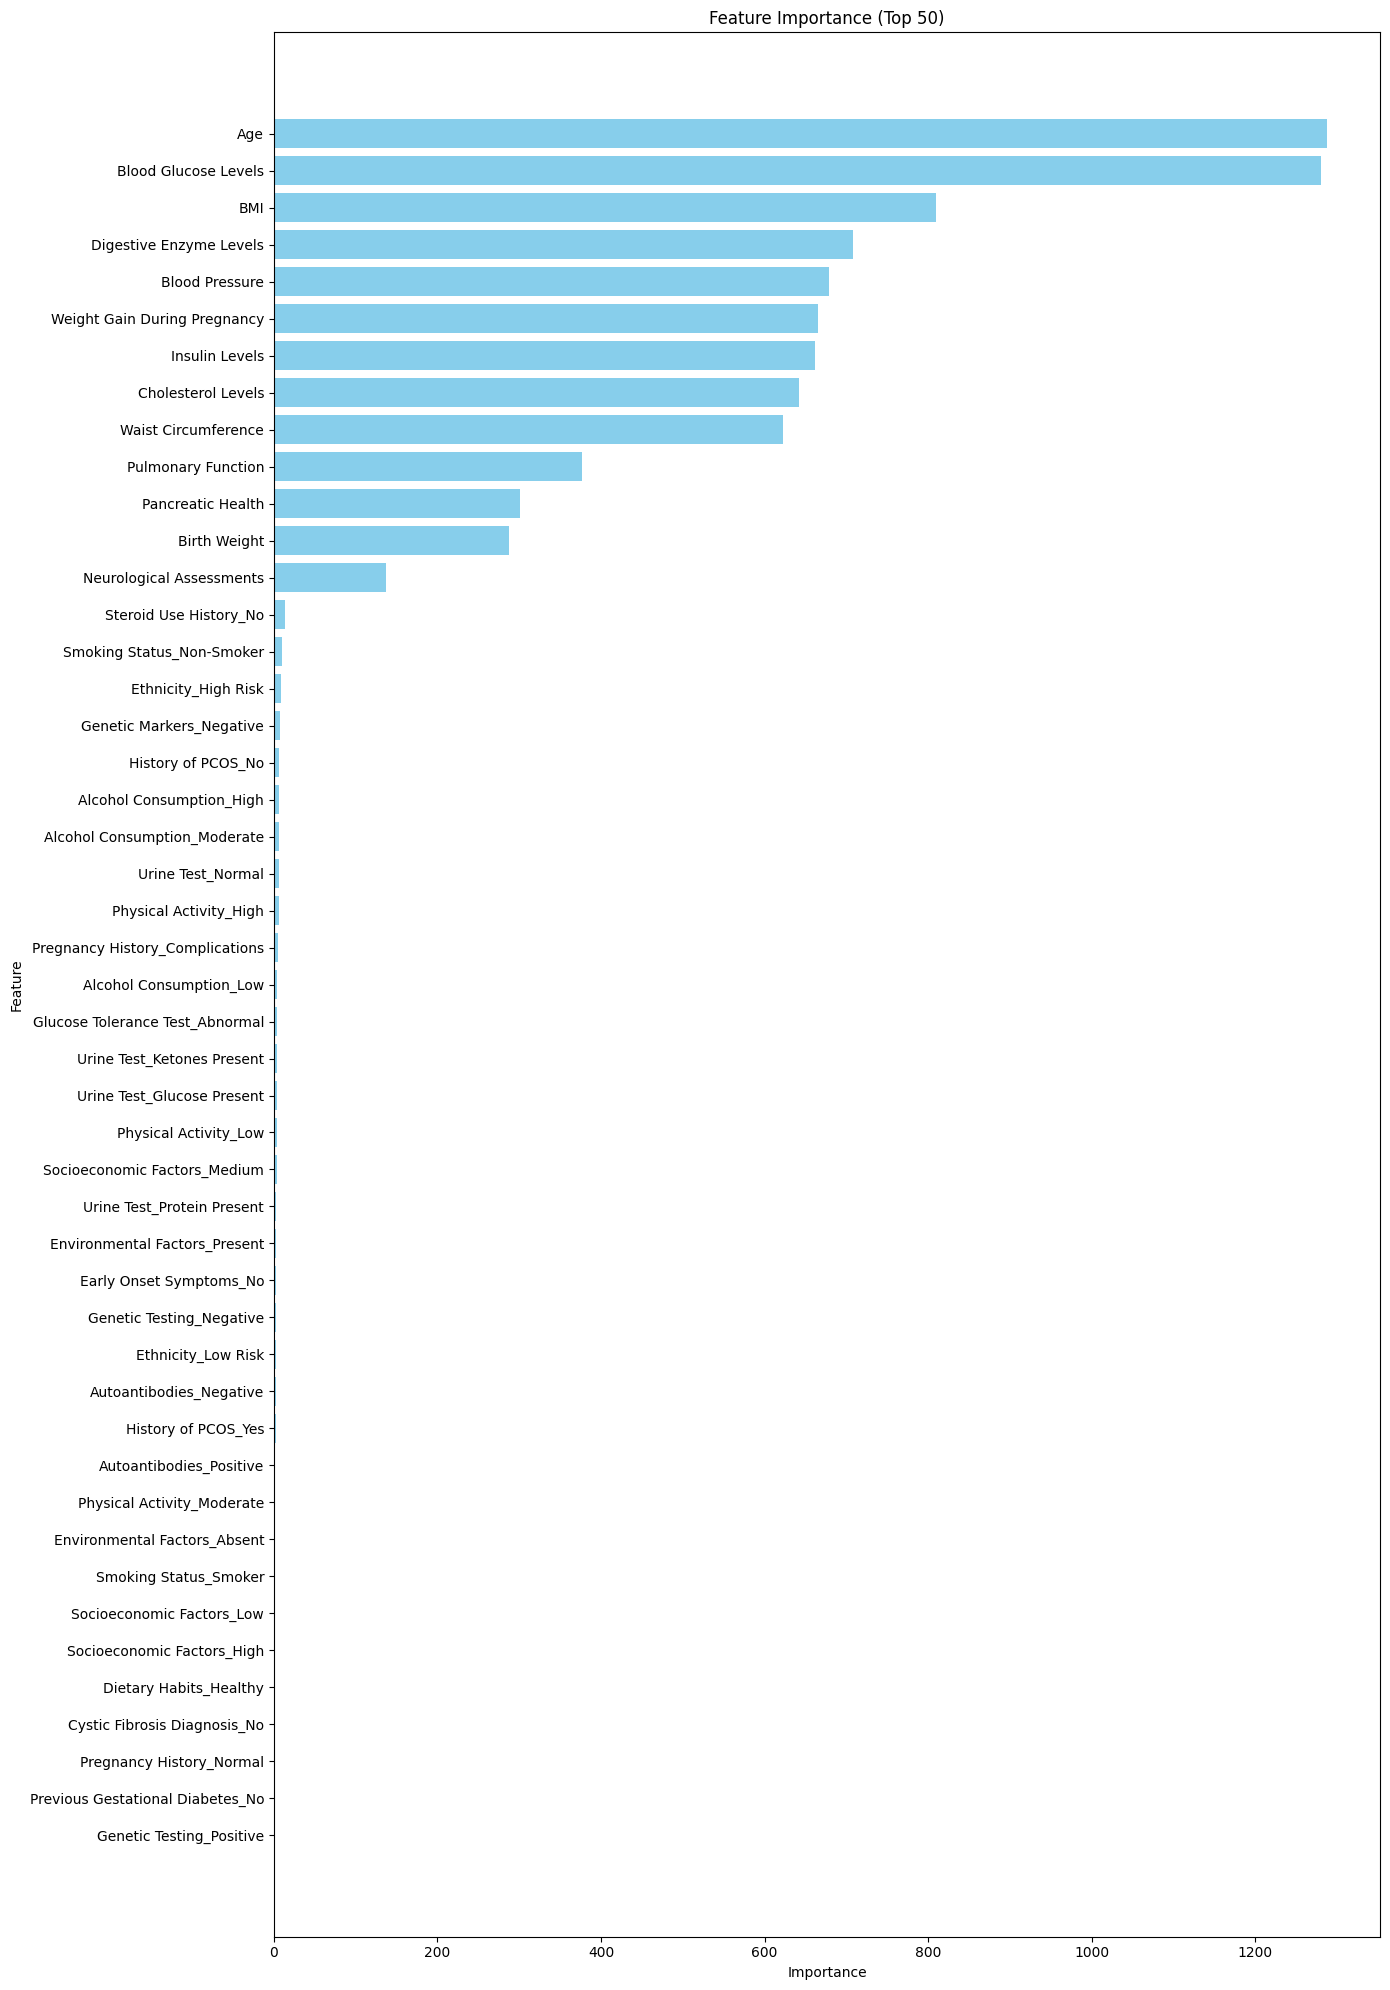

In [9]:
# Get feature importance data
importance = best_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
}).sort_values(by='Importance', ascending=False)

#Keeps all features in data set in feature importance 
top_features = importance_df.head(50)

# Plot
plt.figure(figsize=(14, 20))  # Tall figure for readability
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Top 50)')
plt.tight_layout()
plt.show()

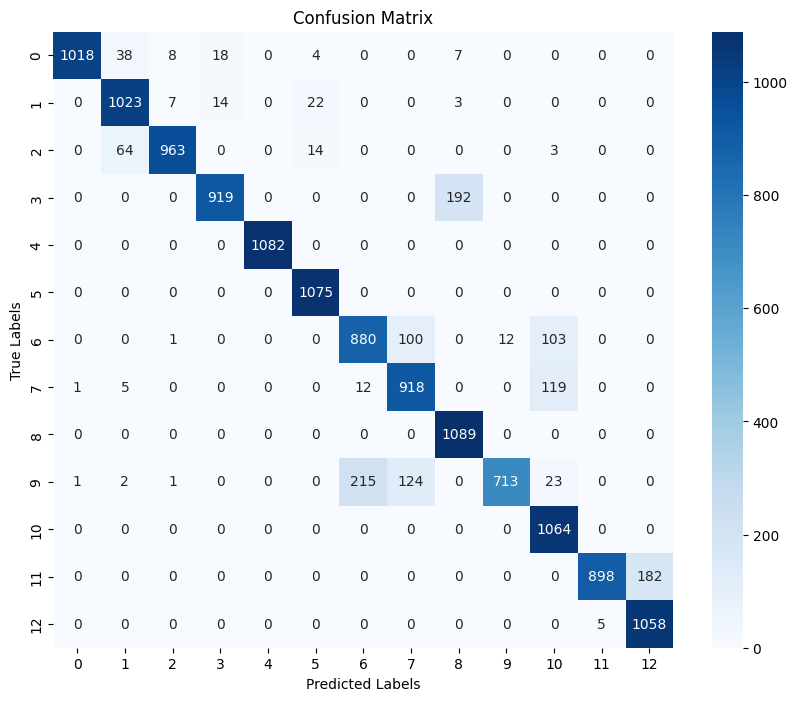

In [10]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [11]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:")
for label, encoded in label_mapping.items():
    print(f"{label}: {encoded}")

Label Mapping:
Cystic Fibrosis-Related Diabetes (CFRD): 0
Gestational Diabetes: 1
LADA: 2
MODY: 3
Neonatal Diabetes Mellitus (NDM): 4
Prediabetic: 5
Secondary Diabetes: 6
Steroid-Induced Diabetes: 7
Type 1 Diabetes: 8
Type 2 Diabetes: 9
Type 3c Diabetes (Pancreatogenic Diabetes): 10
Wolcott-Rallison Syndrome: 11
Wolfram Syndrome: 12
